<a href="https://colab.research.google.com/github/Resia05/supervised-learning/blob/main/model2_12_06_HW_2_7_%D0%9B%D0%BE%D0%B3%D1%96%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%B0_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%96%D1%8F_%D0%B7_scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Імпорт бібліотек

In [146]:
# from google.colab import drive
# drive.mount('/content/drive') # закоментувала, щоб не підклбчатись щоразу. При першому запуску кода потрібно прибрати комент

In [147]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.metrics import roc_auc_score
import joblib
import warnings

# Завантаження даних

В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [148]:
train_orig_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Змагання_Kaggle/train.csv")
# test_orig_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Змагання_Kaggle/test.csv")
# sample_submission_orig_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Змагання_Kaggle/sample_submission.csv")

# Визначення назв колонок, поділ даних

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [149]:
# Визначимо назви колонок
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
categorical_cols = ['Geography']  # Тільки Geography для OneHotEncoder
label_cols = ['Gender']  # Gender для бінарної заміни
id_cols = ['id']
input_cols = id_cols + numeric_cols + categorical_cols + label_cols
target_col = 'Exited'

# Виділяємо матрицю ознак та цільову змінну
X = train_orig_df[input_cols]
y = train_orig_df[target_col]

# Розділимо дані на навчально-валідаційний і тестовий набори
train_val_df, test_df, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Розділимо навчально-валідаційний набір на власне навчальний і валідаційний набори
train_df, val_df, y_train, y_val = train_test_split(train_val_df, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

# Зберігаємо ID окремо для подальшого використання
train_ids = train_df[id_cols]
val_ids = val_df[id_cols]
test_ids = test_df[id_cols]

# Видаляємо колонку ID з даних
train_inputs = train_df.drop(columns=id_cols)
val_inputs = val_df.drop(columns=id_cols)
test_inputs = test_df.drop(columns=id_cols)

train_targets = y_train
val_targets = y_val
test_targets = y_test

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [150]:
# Визначимо числові та категоріальні колонки
numeric_cols_test = train_orig_df.select_dtypes(include='number').columns
categorical_cols_test = train_orig_df.select_dtypes(include='object').columns

print("Numeric columns_test:", numeric_cols_test)
print("Categorical columns_test:", categorical_cols_test)
print("Numeric_cols:", numeric_cols)
print("Id columns:", id_cols)

Numeric columns_test: Index(['id', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')
Categorical columns_test: Index(['Surname', 'Geography', 'Gender'], dtype='object')
Numeric_cols: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Id columns: ['id']


Я використовувала далі в моделі створені вручну назви колонок. Так як я хотіла виключити ID з аналізу, але не хотіла видаляти їх повністю з моделі. Так як колонок мало, то я звірила вручну чи нічого не пропустила, але в разі великої к-сті колонок я б шукала формулу для перевірки чи все з набору даних потрапило.

# Підготовка даних

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

Перевірку на пропуски та інші етапи EDA я зробила в окремому файлі, щоб було зручніше запускати весь код з нуля і тестувати покращення моєї моделі

In [151]:
# Бінарна заміна для стовпця "Gender"
train_inputs['Gender'] = train_inputs['Gender'].map({'Male': 1, 'Female': 0})
val_inputs['Gender'] = val_inputs['Gender'].map({'Male': 1, 'Female': 0})
test_inputs['Gender'] = test_inputs['Gender'].map({'Male': 1, 'Female': 0})

In [152]:
display(test_inputs.head(5))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography,Gender
6490,714.0,46.0,1.0,115764.32,4.0,1.0,1.0,72945.32,Germany,1
3646,593.0,41.0,5.0,0.00,2.0,1.0,1.0,38196.24,France,1
5306,731.0,38.0,2.0,0.00,2.0,0.0,1.0,116971.05,France,0
652,673.0,43.0,4.0,155739.76,1.0,0.0,1.0,111622.76,France,0
2627,678.0,30.0,4.0,0.00,2.0,1.0,0.0,143681.85,Spain,0


In [153]:
display(val_inputs.head(5))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography,Gender
4434,559.0,40.0,7.0,133628.09,1.0,0.0,1.0,184581.68,France,1
8707,742.0,34.0,7.0,0.00,2.0,0.0,1.0,166317.71,France,1
679,773.0,34.0,7.0,0.00,2.0,1.0,0.0,94003.11,France,1
4765,599.0,39.0,4.0,0.00,2.0,1.0,1.0,126796.69,France,1
9354,706.0,39.0,9.0,99713.87,2.0,1.0,1.0,130404.53,Germany,0


In [154]:
display(train_inputs.head(5))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography,Gender
63,743.0,36.0,5.0,0.00,2.0,0.0,1.0,89893.60,France,1
13717,607.0,35.0,6.0,0.00,2.0,1.0,1.0,152733.89,France,1
13292,775.0,33.0,6.0,121355.99,1.0,1.0,0.0,141152.28,France,0
9615,586.0,48.0,1.0,0.00,1.0,0.0,1.0,149946.43,Spain,1
1618,710.0,32.0,5.0,0.00,2.0,1.0,0.0,68400.14,France,1


In [155]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit on train data and transform train data
encoded_train_cols = encoder.fit_transform(train_inputs[categorical_cols])
encoded_train_cols_df = pd.DataFrame(encoded_train_cols, columns=encoder.get_feature_names_out(categorical_cols), index=train_inputs.index)
train_inputs_encoded = pd.concat([train_inputs.drop(columns=categorical_cols), encoded_train_cols_df], axis=1)

# Transform validation data
encoded_val_cols = encoder.transform(val_inputs[categorical_cols])
encoded_val_cols_df = pd.DataFrame(encoded_val_cols, columns=encoder.get_feature_names_out(categorical_cols), index=val_inputs.index)
val_inputs_encoded = pd.concat([val_inputs.drop(columns=categorical_cols), encoded_val_cols_df], axis=1)

# Transform test data
encoded_test_cols = encoder.transform(test_inputs[categorical_cols])
encoded_test_cols_df = pd.DataFrame(encoded_test_cols, columns=encoder.get_feature_names_out(categorical_cols), index=test_inputs.index)
test_inputs_encoded = pd.concat([test_inputs.drop(columns=categorical_cols), encoded_test_cols_df], axis=1)


In [156]:
display(test_inputs_encoded.head(5))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender,Geography_France,Geography_Germany,Geography_Spain
6490,714.0,46.0,1.0,115764.32,4.0,1.0,1.0,72945.32,1,0.0,1.0,0.0
3646,593.0,41.0,5.0,0.00,2.0,1.0,1.0,38196.24,1,1.0,0.0,0.0
5306,731.0,38.0,2.0,0.00,2.0,0.0,1.0,116971.05,0,1.0,0.0,0.0
652,673.0,43.0,4.0,155739.76,1.0,0.0,1.0,111622.76,0,1.0,0.0,0.0
2627,678.0,30.0,4.0,0.00,2.0,1.0,0.0,143681.85,0,0.0,0.0,1.0


In [157]:
display(val_inputs_encoded.head(5))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender,Geography_France,Geography_Germany,Geography_Spain
4434,559.0,40.0,7.0,133628.09,1.0,0.0,1.0,184581.68,1,1.0,0.0,0.0
8707,742.0,34.0,7.0,0.00,2.0,0.0,1.0,166317.71,1,1.0,0.0,0.0
679,773.0,34.0,7.0,0.00,2.0,1.0,0.0,94003.11,1,1.0,0.0,0.0
4765,599.0,39.0,4.0,0.00,2.0,1.0,1.0,126796.69,1,1.0,0.0,0.0
9354,706.0,39.0,9.0,99713.87,2.0,1.0,1.0,130404.53,0,0.0,1.0,0.0


In [158]:
display(train_inputs_encoded.head(5))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender,Geography_France,Geography_Germany,Geography_Spain
63,743.0,36.0,5.0,0.00,2.0,0.0,1.0,89893.60,1,1.0,0.0,0.0
13717,607.0,35.0,6.0,0.00,2.0,1.0,1.0,152733.89,1,1.0,0.0,0.0
13292,775.0,33.0,6.0,121355.99,1.0,1.0,0.0,141152.28,0,1.0,0.0,0.0
9615,586.0,48.0,1.0,0.00,1.0,0.0,1.0,149946.43,1,0.0,0.0,1.0
1618,710.0,32.0,5.0,0.00,2.0,1.0,0.0,68400.14,1,1.0,0.0,0.0


In [159]:
scaler = MinMaxScaler()

# Fit on train data and transform train data
train_inputs_encoded[numeric_cols] = scaler.fit_transform(train_inputs_encoded[numeric_cols])

# Transform validation data
val_inputs_encoded[numeric_cols] = scaler.transform(val_inputs_encoded[numeric_cols])

# Transform test data
test_inputs_encoded[numeric_cols] = scaler.transform(test_inputs_encoded[numeric_cols])


In [160]:
display(test_inputs_encoded.head(5))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender,Geography_France,Geography_Germany,Geography_Spain
6490,0.675418,0.518519,0.1,0.551870,1.000000,1.0,1.0,0.364704,1,0.0,1.0,0.0
3646,0.386635,0.425926,0.5,0.000000,0.333333,1.0,1.0,0.190942,1,1.0,0.0,0.0
5306,0.715990,0.370370,0.2,0.000000,0.333333,0.0,1.0,0.584853,0,1.0,0.0,0.0
652,0.577566,0.462963,0.4,0.742441,0.000000,0.0,1.0,0.558109,0,1.0,0.0,0.0
2627,0.589499,0.222222,0.4,0.000000,0.333333,1.0,0.0,0.718420,0,0.0,0.0,1.0


In [161]:
display(val_inputs_encoded.head(5))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender,Geography_France,Geography_Germany,Geography_Spain
4434,0.305489,0.407407,0.7,0.637030,0.000000,0.0,1.0,0.922939,1,1.0,0.0,0.0
8707,0.742243,0.296296,0.7,0.000000,0.333333,0.0,1.0,0.831610,1,1.0,0.0,0.0
679,0.816229,0.296296,0.7,0.000000,0.333333,1.0,0.0,0.470003,1,1.0,0.0,0.0
4765,0.400955,0.388889,0.4,0.000000,0.333333,1.0,1.0,0.633986,1,1.0,0.0,0.0
9354,0.656325,0.388889,0.9,0.475355,0.333333,1.0,1.0,0.652027,0,0.0,1.0,0.0


In [162]:
display(train_inputs_encoded.head(5))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender,Geography_France,Geography_Germany,Geography_Spain
63,0.744630,0.333333,0.5,0.000000,0.333333,0.0,1.0,0.449453,1,1.0,0.0,0.0
13717,0.420048,0.314815,0.6,0.000000,0.333333,1.0,1.0,0.763684,1,1.0,0.0,0.0
13292,0.821002,0.277778,0.6,0.578527,0.000000,1.0,0.0,0.705771,0,1.0,0.0,0.0
9615,0.369928,0.555556,0.1,0.000000,0.000000,0.0,1.0,0.749746,1,0.0,0.0,1.0
1618,0.665871,0.259259,0.5,0.000000,0.333333,1.0,0.0,0.341975,1,1.0,0.0,0.0


Я використала:
 - OneHotEncoder для перетворення категоріальної колонки Geography в числові 0 та 1.
 - Бінарну заміну для Gender  на 0 та 1
 - MinMaxScaler для всіх категоріальних колонок, щоб нормалізувати їх.

# Збереження наборів даних

5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [163]:
# Перетворення серій у DataFrame
train_inputs_df = pd.DataFrame(train_inputs)
train_targets_df = pd.DataFrame(train_targets)
val_inputs_df = pd.DataFrame(val_inputs)
val_targets_df = pd.DataFrame(val_targets)

# Збереження даних у форматі Parquet
train_inputs_df.to_parquet('train_inputs.parquet')
train_targets_df.to_parquet('train_targets.parquet')  # Оновлено на train_targets_df
val_inputs_df.to_parquet('val_inputs.parquet')
val_targets_df.to_parquet('val_targets.parquet')

# Перевірка наявності збережених файлів
print("Список файлів у поточній папці:")
!ls

Список файлів у поточній папці:
drive		sample_data		       train_inputs.parquet   val_inputs.parquet
log_reg.joblib	submission_log_reg_1206_1.csv  train_targets.parquet  val_targets.parquet


# Навчання моделі

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [164]:
model = LogisticRegression()
model.fit(train_inputs_encoded, train_targets)

LogisticRegression()

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

Training Confusion Matrix:
 [[6890  279]
 [ 860  971]]
Validation Confusion Matrix:
 [[2282  107]
 [ 276  335]]
Training AUROC: 0.8847405606349139
Validation AUROC: 0.876386520598022
Training F1 Score: 0.6303148328464785
Validation F1 Score: 0.6362773029439697


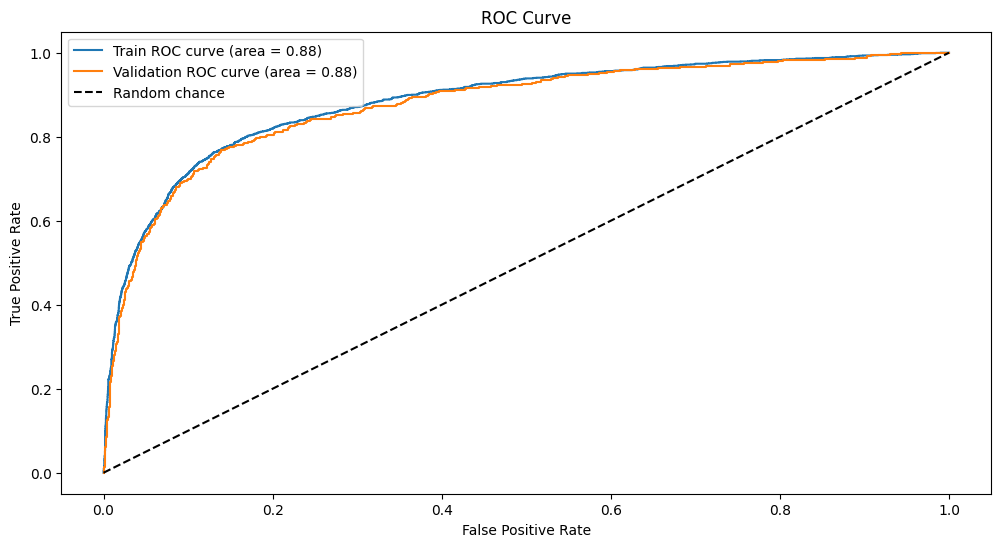

In [165]:
# Прогнози на тренувальних даних
train_preds = model.predict(train_inputs_encoded)
train_proba = model.predict_proba(train_inputs_encoded)[:, 1]

# Прогнози на валідаційних даних
val_preds = model.predict(val_inputs_encoded)
val_proba = model.predict_proba(val_inputs_encoded)[:, 1]

# Confusion matrix
train_cm = confusion_matrix(train_targets, train_preds)
val_cm = confusion_matrix(val_targets, val_preds)

print("Training Confusion Matrix:\n", train_cm)
print("Validation Confusion Matrix:\n", val_cm)

# ROC Curve і AUROC для тренувальних даних
train_fpr, train_tpr, _ = roc_curve(train_targets, train_proba)
train_auroc = roc_auc_score(train_targets, train_proba)

# ROC Curve і AUROC для валідаційних даних
val_fpr, val_tpr, _ = roc_curve(val_targets, val_proba)
val_auroc = roc_auc_score(val_targets, val_proba)

print("Training AUROC:", train_auroc)
print("Validation AUROC:", val_auroc)

# F1 Score для порогу 0.5
train_f1 = f1_score(train_targets, train_preds)
val_f1 = f1_score(val_targets, val_preds)

print("Training F1 Score:", train_f1)
print("Validation F1 Score:", val_f1)

# Побудова ROC Curve
plt.figure(figsize=(12, 6))
plt.plot(train_fpr, train_tpr, label=f'Train ROC curve (area = {train_auroc:.2f})')
plt.plot(val_fpr, val_tpr, label=f'Validation ROC curve (area = {val_auroc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


Загалом якість моделі непогана. Але буду  шукати ще додаткові методи покращення. Також хочу спробувати навчати модель не відразу на всіх даних, а знайти кореляцію і обрати топ стовпців на яких буду навчати модель.

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [166]:
# Визначення мажоритарного класу у тренувальних даних
majority_class = train_targets.mode()[0]

# Передбачення мажоритарного класу для тренувальних та валідаційних даних
train_preds_majority = [majority_class] * len(train_targets)
val_preds_majority = [majority_class] * len(val_targets)

# Обчислення точності передбачень для мажоритарного класу
train_accuracy_majority = accuracy_score(train_targets, train_preds_majority)
val_accuracy_majority = accuracy_score(val_targets, val_preds_majority)

print("Accuracy for Majority Class on Training Data:", train_accuracy_majority)
print("Accuracy for Majority Class on Validation Data:", val_accuracy_majority)


Accuracy for Majority Class on Training Data: 0.7965555555555556
Accuracy for Majority Class on Validation Data: 0.7963333333333333


In [167]:
# Визначення менш часто зустрічаючого класу у тренувальних даних
# minority_class = train_targets.value_counts().idxmin()

# Передбачення менш часто зустрічаючого класу для тренувальних та валідаційних даних
# train_preds_minority = [minority_class] * len(train_targets)
# val_preds_minority = [minority_class] * len(val_targets)

# Обчислення точності передбачень для менш часто зустрічаючого класу
# train_accuracy_minority = accuracy_score(train_targets, train_preds_minority)
# val_accuracy_minority = accuracy_score(val_targets, val_preds_minority)

# print("Accuracy for Minority Class on Training Data:", train_accuracy_minority)
# print("Accuracy for Minority Class on Validation Data:", val_accuracy_minority)

Якість моделі погана, а також гірша від створеної нами. Тобто нашу модель уже можна використовувати.

# Збереження моделі

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [168]:
# Збереження моделі
joblib.dump(model, 'log_reg.joblib')

# Завантаження моделі
model_2 = joblib.load('log_reg.joblib')

# Перевірка, що завантажена модель працює правильно
val_preds_2 = model_2.predict(val_inputs_encoded)
val_accuracy_2 = accuracy_score(val_targets, val_preds_2)
print("Validation Accuracy of loaded model:", val_accuracy_2)


Validation Accuracy of loaded model: 0.8723333333333333


10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [169]:
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    # Бінарна заміна для стовпця "Gender"
    input_df['Gender'] = input_df['Gender'].map({'Male': 1, 'Female': 0})

    # Кодування категоріальних колонок
    input_df_encoded = encoder.transform(input_df[categorical_cols])
    input_df_encoded_df = pd.DataFrame(input_df_encoded, columns=encoder.get_feature_names_out(categorical_cols))

    # Масштабування числових колонок
    input_df_scaled = scaler.transform(input_df[numeric_cols])
    input_df_scaled_df = pd.DataFrame(input_df_scaled, columns=numeric_cols)

    # Додаємо Gender до числових колонок
    input_df_scaled_df['Gender'] = input_df['Gender'].values

    # Побудова вхідної матриці для передбачення
    X_input = pd.concat([input_df_scaled_df, input_df_encoded_df], axis=1)

    # Передбачення ймовірностей належності до класу 1
    prob = model.predict_proba(X_input)[:, 1]

    return prob


In [170]:
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    # Бінарна заміна для стовпця "Gender"
    input_df['Gender'] = input_df['Gender'].map({'Male': 1, 'Female': 0})

    # Кодування категоріальних колонок
    input_df_encoded = encoder.transform(input_df[categorical_cols])
    input_df_encoded_df = pd.DataFrame(input_df_encoded, columns=encoder.get_feature_names_out(categorical_cols))

    # Масштабування числових колонок
    input_df_scaled = scaler.transform(input_df[numeric_cols])
    input_df_scaled_df = pd.DataFrame(input_df_scaled, columns=numeric_cols)

    # Додаємо Gender до числових колонок
    input_df_scaled_df['Gender'] = input_df['Gender'].values

    # Побудова вхідної матриці для передбачення
    X_input = pd.concat([input_df_scaled_df, input_df_encoded_df], axis=1)

    # Передбачення ймовірностей належності до класу 1
    prob = model.predict_proba(X_input)[:, 1]

    return prob

# Передбачення результатів за допомогою нашої моделі

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [171]:
test_raw_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Змагання_Kaggle/test.csv")
test_raw_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,15642997.0,Chukwumaobim,639.0,Spain,Male,38.0,10.0,0.00,2.0,1.0,1.0,49637.65
9996,24996,15739271.0,Clements,678.0,Spain,Male,39.0,9.0,0.00,2.0,1.0,1.0,142513.50
9997,24997,15756743.0,Chidiebere,774.0,France,Male,30.0,9.0,0.00,2.0,1.0,0.0,4861.72
9998,24998,15680167.0,Yermakova,595.0,France,Male,38.0,6.0,144875.79,1.0,1.0,0.0,126469.09


In [172]:
# Здійснюємо передбачення для колонки Exited
predictions = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, test_raw_df)

# Вставляємо передбачені значення в колонку Exited набору test_raw_df
test_raw_df['Exited'] = predictions

# Виводимо перші 5 рядків фінального датасету
print(test_raw_df.head())

      id  CustomerId     Surname  CreditScore Geography  Gender   Age  Tenure  \
0  15000  15594796.0         Chu        584.0   Germany       1  30.0     2.0   
1  15001  15642821.0       Mazzi        551.0    France       1  39.0     5.0   
2  15002  15716284.0   Onyekachi        706.0    France       1  43.0     8.0   
3  15003  15785078.0      Martin        717.0     Spain       1  45.0     3.0   
4  15004  15662955.0  Kenechukwu        592.0     Spain       1  43.0     8.0   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0  146053.66            1.0        1.0             1.0        157891.86   
1       0.00            2.0        1.0             1.0         67431.28   
2       0.00            2.0        1.0             0.0        156768.45   
3       0.00            1.0        1.0             1.0        166909.87   
4       0.00            2.0        1.0             1.0        143681.97   

     Exited  
0  0.077349  
1  0.035269  
2  0.164389  
3  0.1

12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [173]:
# Зчитуємо файл 'sample_submission.csv'
sample_submission_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Змагання_Kaggle/sample_submission.csv")

In [174]:
# 3. Збереження результатів
sample_submission_df['Exited'] = test_raw_df['Exited']

# 4. Збереження файлу
sample_submission_df.to_csv('submission_log_reg_1206_1.csv', index=False)
sample_submission_df

,id,Exited
0,15000,0.077349
1,15001,0.035269
2,15002,0.164389
3,15003,0.187227
4,15004,0.054451
...,...,...
9995,24995,0.020095
9996,24996,0.025342
9997,24997,0.017654
9998,24998,0.155913
